In [1]:
import parselmouth
import librosa
import pyworld as pw
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import yaml

with open('config.yaml') as fopen:
    config = yaml.safe_load(fopen)
    
config

{'sampling_rate': 22050,
 'fft_size': 1024,
 'hop_size': 256,
 'win_length': None,
 'window': 'hann',
 'num_mels': 80,
 'fmin': 80,
 'fmax': 7600,
 'global_gain_scale': 1.0,
 'trim_silence': True,
 'trim_threshold_in_db': 60,
 'trim_frame_size': 2048,
 'trim_hop_size': 512}

In [3]:
import numpy as np

# https://github.com/TensorSpeech/TensorFlowTTS/blob/master/tensorflow_tts/utils/outliers.py
def is_outlier(x, p25, p75):
    """Check if value is an outlier."""
    lower = p25 - 1.5 * (p75 - p25)
    upper = p75 + 1.5 * (p75 - p25)
    return x <= lower or x >= upper


def remove_outlier(x, p_bottom: int = 25, p_top: int = 75):
    """Remove outlier from x."""
    p_bottom = np.percentile(x, p_bottom)
    p_top = np.percentile(x, p_top)

    indices_of_outliers = []
    for ind, value in enumerate(x):
        if is_outlier(value, p_bottom, p_top):
            indices_of_outliers.append(ind)

    x[indices_of_outliers] = 0.0
    x[indices_of_outliers] = np.max(x)
    return x

In [4]:
import re

_pad = 'pad'
_start = 'start'
_eos = 'eos'
_punctuation = "!'(),.:;? "
_special = '-'
_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

MALAYA_SPEECH_SYMBOLS = (
    [_pad, _start, _eos] + list(_special) + list(_punctuation) + list(_letters)
)

In [5]:
def tts_encode(string: str, add_eos: bool = True):
    r = [MALAYA_SPEECH_SYMBOLS.index(c) for c in string if c in MALAYA_SPEECH_SYMBOLS]
    if add_eos:
        r = r + [MALAYA_SPEECH_SYMBOLS.index('eos')]
    return r

In [6]:
from glob import glob

files = glob('../malaya/postprocessing*-yasmin.json')
files

['../malaya/postprocessing-edge-tts-news-yasmin.json',
 '../malaya/postprocessing-edge-tts-parliament-yasmin.json']

In [9]:
import json

with open('../malaya/postprocessing-edge-tts-news-yasmin.json') as fopen:
    text = json.load(fopen)
    
with open('postprocessing-edge-tts-parliament-yasmin.json') as fopen:
    parliament = json.load(fopen)

In [10]:
parliament[0], text[0]

(['yasmin-parliament-edge-tts-text/47434.json', 'TETAPI Semeling MP Sg .'],
 ['yasmin-news-edge-tts-text/138.json',
  'Ketika perang Aceh meletus pada tahun seribu lapan ratus tujuh puluh tiga , Teuku Ibrahim Lamnga aktif berjuang di garisan depan .'])

In [11]:
len(text), len(parliament)

(48774, 57130)

In [8]:
# !wget https://gist.githubusercontent.com/huseinzol05/98974ae8c6c7a65d4bc0af9f5003786a/raw/5aa5257608b61e8fcc828e99fbd070d5ca7358e3/mp.py

In [9]:
text[0]

['yasmin-news-edge-tts-text/138.json',
 'Ketika perang Aceh meletus pada tahun seribu lapan ratus tujuh puluh tiga , Teuku Ibrahim Lamnga aktif berjuang di garisan depan .']

In [10]:
!rm -rf output-yasmin

In [11]:
directory = 'output-yasmin'
os.system(f'mkdir {directory}')
directories = ['audios', 'mels', 'text_ids', 'f0s', 'energies', 'pitches']
for d in directories:
    os.system(f'mkdir {directory}/{d}')

In [12]:
!mv ../malaya/yasmin-news-edge-tts-wav .

mv: cannot stat '../malaya/yasmin-news-edge-tts-wav': No such file or directory


In [13]:
os.path.split(text[0][0])[1].replace('.json', '')

'138'

In [14]:
txts = []
for t in text:
    index = os.path.split(t[0])[1].replace('.json', '')
    wav = t[0].replace('-text', '-wav').replace('.json', '.wav')
    if os.path.exists(wav):
        txts.append((wav, t[1], index, directory))

In [15]:
txts[0]

('yasmin-news-edge-tts-wav/138.wav',
 'Ketika perang Aceh meletus pada tahun seribu lapan ratus tujuh puluh tiga , Teuku Ibrahim Lamnga aktif berjuang di garisan depan .',
 '138',
 'output-yasmin')

In [17]:
import malaya_speech
from malaya_speech import Pipeline
from tqdm import tqdm
vad = malaya_speech.vad.webrtc()

def process(txts, 
            start_silent_trail = int(0.1 * config['sampling_rate']),
            middle_silent_trail = int(0.12 * config['sampling_rate']),
            end_silent_trail = int(0.1 * config['sampling_rate']),
            process_middle_silent = True,
            maxlen = 25):
    
    txts = txts[0]
    audios, mels, text_ids, f0s, energies, pitches = [], [], [], [], [], []

    for f in txts:
        directory = f[3]
        index = f[2]
        text = f[1]
        f = f[0]
            
        text = [text, tts_encode(text)]
        try:
            audio, _ = malaya_speech.load(f, sr = config['sampling_rate'])
        except:
            continue
        audio = audio[start_silent_trail:]

        if config['trim_silence']:
            y_= malaya_speech.resample(audio, config['sampling_rate'], 16000)
            y_ = malaya_speech.astype.float_to_int(y_)
            frames = list(malaya_speech.generator.frames(audio, 30, config['sampling_rate']))
            frames_ = list(malaya_speech.generator.frames(y_, 30, 16000, append_ending_trail = False))
            frames_webrtc = [(frames[no], vad(frame)) for no, frame in enumerate(frames_)]
            grouped_deep = malaya_speech.group.group_frames(frames_webrtc)
            grouped_deep = malaya_speech.group.group_frames_threshold(grouped_deep, 0.15)
            r = []
            for no, g in enumerate(grouped_deep):
                if g[1]:
                    g = g[0].array
                else:
                    if no == 0:
                        g = g[0].array[-start_silent_trail:]
                    elif no == (len(grouped_deep) - 1):
                        g = g[0].array[:end_silent_trail]
                    else:
                        if process_middle_silent:
                            g = np.concatenate([g[0].array[:middle_silent_trail], g[0].array[-middle_silent_trail:]])
                        else:
                            g = g[0].array
                        
                r.append(g)
            audio = np.concatenate(r)
        
        if (len(audio) / config['sampling_rate']) > maxlen:
            print('skipped, audio too long')
            continue

        D = librosa.stft(
            audio,
            n_fft=config['fft_size'],
            hop_length=config['hop_size'],
            win_length=config['win_length'],
            window=config['window'],
            pad_mode='reflect',
        )
        S, _ = librosa.magphase(D) 
        fmin = 0 if config["fmin"] is None else config["fmin"]
        fmax = sampling_rate // 2 if config["fmax"] is None else config["fmax"]
        mel_basis = librosa.filters.mel(
            sr=config['sampling_rate'],
            n_fft=config["fft_size"],
            n_mels=config["num_mels"],
            fmin=fmin,
            fmax=fmax,
        )
        mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
        audio = np.pad(audio, (0, config["fft_size"]), mode="edge")
        audio = audio[: len(mel) * config['hop_size']]

        _f0, t = pw.dio(
            audio.astype(np.double),
            fs=config['sampling_rate'],
            f0_ceil=fmax,
            frame_period=1000 * config['hop_size'] / config['sampling_rate'],
        )
        f0 = pw.stonemask(audio.astype(np.double), _f0, t, config['sampling_rate'])
        if len(f0) >= len(mel):
            f0 = f0[: len(mel)]
        else:
            f0 = np.pad(f0, (0, len(mel) - len(f0)))

        # extract energy
        energy = np.sqrt(np.sum(S ** 2, axis=0))
        f0 = remove_outlier(f0)
        energy = remove_outlier(energy)
        
        mel_len = len(mel)
        snd = parselmouth.Sound(audio,sampling_frequency=22050)
        pitch = snd.to_pitch(time_step=snd.duration / (mel_len + 3)
                         ).selected_array['frequency']

        if config["global_gain_scale"] > 0.0:
            audio *= config["global_gain_scale"]

        if len(energy[energy != 0]) == 0 or len(f0[f0 != 0]) == 0:
            print('skipped')
            continue
            
        np.save(f'{directory}/audios/{index}.npy', audio.astype(np.float32))
        np.save(f'{directory}/mels/{index}.npy', mel.astype(np.float32))
        np.save(f'{directory}/text_ids/{index}.npy', text)
        np.save(f'{directory}/f0s/{index}.npy', f0.astype(np.float32))
        np.save(f'{directory}/energies/{index}.npy', energy.astype(np.float32))

        audios.append(audio)
        mels.append(mel)
        text_ids.append(text)
        f0s.append(f0)
        energies.append(energy)
        pitches.append(pitch)
    
    return [[audios, mels, text_ids, f0s, energies, pitches]]

In [13]:
import matplotlib.pyplot as plt
import IPython.display as ipd

In [18]:
%%time

i = 1508
r = process((txts[i: i + 10], 0))[0]

/home/husein/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


CPU times: user 7.1 s, sys: 16 s, total: 23.1 s
Wall time: 1.5 s


In [19]:
for n in range(len(r[2])):
    print(n, r[2][n][0])

0 lima puluh tiga , Jakarta Timur , Indonesia .
1 Mengikut pertuduhan , dia didakwa menakutkan secara jenayah terhadap Mohd .
2 Project sebagai Hello !.
3 Sementara itu , ringgit didagangkan lebih rendah berbanding mata wang utama yang lain .
4 Sekarang , kereta sudah bertambah sehingga tahap kita berdepan kesesakan .
5 Ternakan dan buruan Biasanya haiwan yang diburu adalah termasuk rusa , beruang , bison dan ayam belanda liar .
6 Peranan Pada sembilan belas Julai dua ribu sembilan , baginda dilantik sebagai Penaung Persekutuan Pengakap Malaysia bagi negeri Terengganu .
7 Enam pemancing dikhuatiri hilang di perairan Pulau Pinang setelah tidak pulang ke rumah selepas keluar memancing sejak Sabtu .
8 Catedral da Se ( gereja besar metropolitan , lambang bandaraya ) .
9 Antlers juga berjaya menamatkan saingan di tempat lima teratas dengan peratusan sebanyak tujuh puluh peratus .


In [20]:
k = 4
ipd.Audio(r[0][k], rate = 22050)

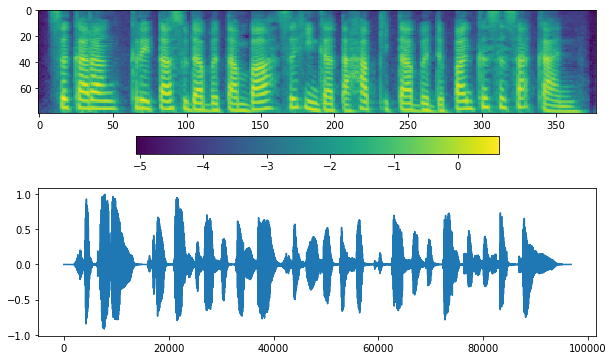

In [21]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(10)
fig.set_figheight(nrows * 3)
mel_outputs_ = np.reshape(r[1][k], [-1, 80])
im = ax[0].imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax[0])
ax[1].plot(r[0][k])
plt.show()

In [24]:
import mp

for i in tqdm(range(0, len(txts), 1000)):
    index = min(i + 1000, len(txts))
    b = txts[i: index]
    mp.multiprocessing(b, process, cores = 3, returned = False)

  0%|                                                                                                         | 0/49 [00:00<?, ?it/s]/home/husein/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/husein/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/husein/.local/lib/python3.8/site-packages/numpy/core/_a

skipped, audio too long


  2%|█▉                                                                                             | 1/49 [01:37<1:17:48, 97.27s/it]/home/husein/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/husein/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/husein/.local/lib/python3.8/site-packages/numpy/core/_a

skipped, audio too long


  4%|███▉                                                                                           | 2/49 [03:12<1:15:28, 96.36s/it]/home/husein/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/husein/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/husein/.local/lib/python3.8/site-packages/numpy/core/_a

skipped, audio too long


  6%|█████▊                                                                                         | 3/49 [04:47<1:13:18, 95.62s/it]/home/husein/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/husein/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/husein/.local/lib/python3.8/site-packages/numpy/core/_a

skipped, audio too long


 18%|█████████████████▍                                                                             | 9/49 [14:22<1:03:55, 95.89s/it]/home/husein/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/husein/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/husein/.local/lib/python3.8/site-packages/numpy/core/_a

skipped, audio too long


 27%|█████████████████████████▍                                                                      | 13/49 [20:44<57:22, 95.63s/it]/home/husein/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/husein/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/husein/.local/lib/python3.8/site-packages/numpy/core/_a

skipped, audio too long


 61%|██████████████████████████████████████████████████████████▊                                     | 30/49 [47:51<30:28, 96.26s/it]/home/husein/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/husein/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/husein/.local/lib/python3.8/site-packages/numpy/core/_a

In [15]:
!du -hs output-yasmin

67G	output-yasmin


In [18]:
!rm -rf output-yasmin-parliament

In [19]:
directory = 'output-yasmin-parliament'
os.system(f'mkdir {directory}')
directories = ['audios', 'mels', 'text_ids', 'f0s', 'energies', 'pitches']
for d in directories:
    os.system(f'mkdir {directory}/{d}')

In [20]:
txts = []
for t in parliament:
    index = os.path.split(t[0])[1].replace('.json', '')
    wav = t[0].replace('-text', '-wav').replace('.json', '.wav')
    if os.path.exists(wav):
        txts.append((wav, t[1], index, directory))
len(txts)

57130

In [21]:
i = 80
r = process((txts[i: i + 10], 0))[0]

/home/husein/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [22]:
for n in range(len(r[2])):
    print(n, r[2][n][0])

0 Purata kos penajaan setahun bagi seorang pelajar tajaan luar negara adalah antara tiga puluh lapan ringgit , seratus lima belas hingga tiga ratus enam puluh tiga ribu lapan ratus empat puluh empat ringgit mengikut negara dan bidang pengajian .
1 Kecekapan Elektrik lndustri Bekalan Elektrik JUMLAH PERUNTUKAN lapan ratus empat puluh satu ribu empat puluh lapan , sembilan ratus dua perpuluhan enam lima .
2 Bumiputera empat ribu empat ratus tujuh puluh lima . lapan seribu tujuh ratus tiga puluh enam . enam dua puluh empat perpuluhan tujuh Cina seribu lima ratus tiga puluh dua . empat enam ratus tujuh perpuluhan satu lapan perpuluhan enam India lima ratus dua puluh tujuh perpuluhan enam dua ratus tiga puluh satu perpuluhan satu tiga perpuluhan tiga Sumber : Penyiasatan Tenaga Buruh , Jabatan Perangkaan Malaysia .
3 KKM juga telah melaksanakan latihan dalam bidang Dermatologi sebagai bidang subkepakaran sejak tahun dua ribu satu .
4 Tuan Yang di .
5 Tuan Lim Kit Siang [ Gelang Patah ] SOAL

In [23]:
k = 0
ipd.Audio(r[0][k], rate = 22050)

In [25]:
import mp

In [26]:
for i in tqdm(range(0, len(txts), 1000)):
    index = min(i + 1000, len(txts))
    b = txts[i: index]
    mp.multiprocessing(b, process, cores = 3, returned = False)

  2%|█▋                                                                                             | 1/58 [01:38<1:33:11, 98.10s/it]

skipped, audio too long


  3%|███▎                                                                                           | 2/58 [03:16<1:31:29, 98.02s/it]

skipped, audio too long


  5%|████▉                                                                                          | 3/58 [04:51<1:28:42, 96.78s/it]

skipped, audio too long


  9%|████████▏                                                                                      | 5/58 [08:06<1:26:02, 97.40s/it]

skipped, audio too long


 16%|██████████████▋                                                                                | 9/58 [14:41<1:20:14, 98.25s/it]

skipped, audio too long


 22%|█████████████████████                                                                         | 13/58 [21:14<1:13:38, 98.19s/it]

skipped, audio too long


 26%|████████████████████████▎                                                                     | 15/58 [24:31<1:10:31, 98.40s/it]

skipped, audio too long


 28%|█████████████████████████▉                                                                    | 16/58 [26:09<1:08:42, 98.16s/it]

skipped, audio too long


 29%|███████████████████████████▌                                                                  | 17/58 [27:47<1:07:06, 98.20s/it]

skipped, audio too long
skipped, audio too long


 38%|████████████████████████████████████▍                                                           | 22/58 [35:59<58:55, 98.22s/it]

skipped, audio too long


 41%|███████████████████████████████████████▋                                                        | 24/58 [39:15<55:41, 98.27s/it]

skipped, audio too long


 43%|█████████████████████████████████████████▍                                                      | 25/58 [40:53<53:59, 98.17s/it]

skipped, audio too long


 50%|████████████████████████████████████████████████                                                | 29/58 [47:25<47:25, 98.13s/it]

skipped, audio too long


 52%|█████████████████████████████████████████████████▋                                              | 30/58 [49:02<45:45, 98.06s/it]

skipped, audio too long


 62%|███████████████████████████████████████████████████████████▌                                    | 36/58 [58:52<36:00, 98.21s/it]

skipped, audio too long


 69%|████████████████████████████████████████████████████████████████▊                             | 40/58 [1:05:24<29:23, 97.95s/it]

skipped, audio too long


 74%|█████████████████████████████████████████████████████████████████████▋                        | 43/58 [1:10:17<24:25, 97.69s/it]

skipped, audio too long


 76%|███████████████████████████████████████████████████████████████████████▎                      | 44/58 [1:11:56<22:53, 98.07s/it]

skipped, audio too long


 93%|███████████████████████████████████████████████████████████████████████████████████████▌      | 54/58 [1:28:18<06:32, 98.03s/it]

skipped, audio too long


 97%|██████████████████████████████████████████████████████████████████████████████████████████▊   | 56/58 [1:31:35<03:16, 98.27s/it]

skipped, audio too long


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [1:33:26<00:00, 96.67s/it]


In [ ]:
files = glob('/home/husein/speech-bahasa/output-yasmin/audios/*.npy')
files.extend(glob('/home/husein/speech-bahasa/output-yasmin-parliament/audios/*.npy'))
files.extend(glob('/home/husein/speech-bahasa/output-yasmin-synthetic/audios/*.npy'))

# files = glob('/home/husein/speech-bahasa/output-osman-synthetic/audios/*.npy')
files = sorted(files)
len(files)

In [ ]:
directory = 'yasmin'
directory = os.path.join(os.getcwd(), directory)
directory

In [ ]:
!rm -r {directory}
!mkdir {directory}

In [ ]:
import json
import malaya
import re
from unidecode import unidecode

normalizer = malaya.normalize.normalizer(date = False, time = False, money = True)

def put_spacing_num(string):
    string = re.sub('[A-Za-z]+', lambda ele: ' ' + ele[0] + ' ', string)
    return re.sub(r'[ ]+', ' ', string).strip()

def convert_to_ascii(string):
    return unidecode(string)

def collapse_whitespace(string):
    return re.sub(_whitespace_re, ' ', string)

def cleaning(string, normalize = True, add_eos = False):
    sequence = []
    string = convert_to_ascii(string)
    string = re.sub(r'[ ]+', ' ', string).strip()
    if string[-1] in ['-', ',']:
        string = string[:-1]
    if string[-1] != '.':
        string = string + '.'
    string = put_spacing_num(string)
    string = re.sub(r'[ ]+', ' ', string).strip()
    string = string
    return string

In [ ]:
from tqdm import tqdm

yasmin = []
for f in tqdm(files):
    text_ids = np.load(f.replace('audios', 'text_ids'), allow_pickle=True)[
        0
    ]
    if 'output-yasmin-synthetic' in f:
        text_ids = cleaning(text_ids)
    text_ids = text_ids.replace('ju ta', 'juta')
    
    filename = f.replace('/', '-').replace('.npy', '.wav')
    audio = np.load(f)
    left = os.path.join(directory, filename)
    sf.write(left, audio, 22050)
    
    yasmin.append((left, text_ids))

In [ ]:
import json

with open('yasmin-vits.json', 'w') as fopen:
    json.dump(yasmin, fopen)